## SNPE inference experiments: Conditional sampling and computing KL divergence and difference in means of sampled posterior distributions

With the inference model trained with 32000 review time series (20 Marketplaces) from the simulated data, the remaining 19200 simulated review time series (12 Marketplaces) can be employed for conditional sampling and evaluation of results according to proposed experiments.

This notebook contains code in charge of drawing conditional posterior samples for time series belonging to the three groups that are relevant for the proposed experiments, to then compute and evaluate the KL divergence and difference in means of the sampled posterior distributions.

For further clarity, the three groups of simulations employed as part of the experiments can be charactrerized as follows: 


   __"Base" group__: Acting as the "control" group, is comprised of the 19200 simulated reviews time series not employed to train the inference model.

   __"Jumbled" group__: Built from the base group. Review time series preserve their number and distribution of reviews but the order of these is altered (i.e. Jumbled) for all products. This is the group of reference for experiment 2.

   __"Augmented" group__: Built from the base group. Review time series preserve their distribution, but the number of reviews is increased by a factor of two for all products. This is the group of reference for experiment 3.



#### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

# Just a formatting related plugin
#%load_ext nb_black

%matplotlib inline
import matplotlib.pyplot as plt

import sys

sys.path.append("../")

import multiprocessing as mp

from collections import deque
from pathlib import Path
from typing import Dict, Optional

import arviz
import pickle

import numpy as np
import pandas as pd
import sbi
import sbi.utils as sbi_utils
import seaborn as sns
import statsmodels.formula.api as smf
import torch

import json

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from snpe.inference import inference_class
from snpe.simulations import simulator_class, marketplace_simulator_class
from snpe.embeddings.embeddings_to_ratings import EmbeddingRatingPredictor
from snpe.utils.statistics import review_histogram_correlation
from snpe.utils.tqdm_utils import tqdm_joblib
from tqdm import tqdm

from scipy.stats import entropy as kl_div

# Set plotting parameters
sns.set(style="white", context="talk", font_scale=2.5)
sns.set_color_codes(palette="colorblind")
sns.set_style("ticks", {"axes.linewidth": 2.0})

#### Paths for retrieval of relevant components

(Adapt at convenience)

In [ ]:
ARTIFACT_PATH = Path("../../../artifacts") # Simulator and Trained inference model employed during conditional sampling
SAMPLING_SIMULATION_PATH = Path("../../../sampling") # Path of simulated data (3 groups: Base, Jumbled and Augmented)

#### Define conditional posterior sampling function

(Recycled from inference tutorial)

In [ ]:
def sample_posterior_with_observed(
    device: str,
    observations: np.array,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
) -> np.ndarray:
    # The parameter prior doesn't matter here as it will be overridden by that of the loaded inference object
    parameter_prior = sbi.utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor
        ),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor
        ),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    inferrer.load_inference(dirname=ARTIFACT_PATH)
    posterior_samples = inferrer.get_posterior_samples(
        observations, num_samples=num_samples
    )
    return posterior_samples

#### Compute and save KL-divergence & Difference in means for all products

Note: The code was originally ran considering 500 samples for every time series.

In [ ]:
# Load base time-series data and experiments' time-series

    # Base time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_base_data.pkl", 'rb') as f:
    base_data = pickle.load(f)
    
    # "Jumbled" time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_1_data.pkl", 'rb') as f:
    exp1_data = pickle.load(f)

    # "Augmented" time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_2_data.pkl", 'rb') as f:
    exp2_data = pickle.load(f)
    
    
# Retrieve simulations data
base_data_timeseries = base_data["simulations"]
exp1_data_timeseries = exp1_data["simulations"]
exp2_data_timeseries = exp2_data["simulations"]


# Initialize a dictionary to store all results

results = {}

# Define Number of samples drawn for each time-series during conditional sampling

num_samples = 5

##################################################################################################
#Loop over all products
##################################################################################################

for marketplace in range(12): # Number of marketplaces
    for product in range(1600): # Number of products ine ach marketplace
        
        augmented = True 
        # Variable "augmented" defined to track whether it was posible to retrieve augmented samples.
        # For those time-series whose augmented version length is longer than the maximum times-series
        # length seen during training by the inference model conditional sampling is not posible and thus
        # in such cases this variable is used to record that condition for a given time-series and skip 
        # augmented-related processign steps of this code cell.
        
        augmented_failed = []
        # A list is also initialized to store product number-IDs of those product whose augmented time-series
        # are too long as described above.
    
        # Get product number from the combination of marketplace and product
        parameter_n = ((marketplace)*1600) + (product)
        
        # Progress report
        if parameter_n % 192 == 0 and parameter_n != 0:
            percent_complete = (parameter_n / 19200) * 100
            print(f"Progress: {percent_complete}% complete")

        # Reshape timeseries to use as part of "sample_posterior_with_obeserved()"
        
        base_dt = np.empty((1,), dtype=object) # Base 
        base_dt[0] = base_data_timeseries[marketplace][product]
        
        exp1_dt = np.empty((1,), dtype=object) # Experiment 1 
        exp1_dt[0] = exp1_data_timeseries[marketplace][product]
        
        exp2_dt = np.empty((1,), dtype=object) # Experiment 2 
        exp2_dt[0] = exp2_data_timeseries[marketplace][product]
        
    
        ##################################################################################################
        #Conditional sampling
        ##################################################################################################
        
        # Original timeseries
        posterior_samples_base = sample_posterior_with_observed(
            "cpu", base_dt, num_samples, "marketplace", "timeseries");
        
        # Jumbled time series
        posterior_samples_exp1 = sample_posterior_with_observed(
            "cpu", exp1_dt, num_samples, "marketplace", "timeseries");
        
        try:
            
            # "Augmented" time series
            posterior_samples_exp2 = sample_posterior_with_observed(
                "cpu", exp2_dt, num_samples, "marketplace", "timeseries");
            
        except:
            
            # If augmented time-series length is above the limit, the product id(s)
            # is stored and "augmented" is set to False so all subsequent steps related
            # to the augmented time-series is skipped.
            
            augmented == False
            augmented_failed.append((marketplace, product, parameter_n))
        
        
        ##################################################################################################
        #KL divergence
        ##################################################################################################
        
        # Define histogram bins edges edges for rho parameters and h_p
        # 20 bins are considered (hence 21 edges are defined)
        rho_edges = np.linspace(0,4,21)
        herding_edges = np.linspace(0,1,21)
        
            # Rho-
        hist_base_rho_minus, bin_edges = np.histogram(posterior_samples_base[:, :, 0], bins=rho_edges)
        hist_base_rho_minus = hist_base_rho_minus/num_samples

        
        hist_jumbled_rho_minus, bin_edges = np.histogram(posterior_samples_exp1[:, :, 0], bins=rho_edges)
        hist_jumbled_rho_minus = hist_jumbled_rho_minus/num_samples
        
            # KL divergence: computed considering the addition of a small constant to all bins to avoid 
            # getting +/- infinity values.
        rho_minus_jumbled_kl_div = kl_div((hist_base_rho_minus+0.0001), (hist_jumbled_rho_minus+0.0001))
        
        
            # If augmented == False, KL divergence is not computed for augmented Time-Series
        if augmented != False:
            
            hist_augmented_rho_minus, bin_edges = np.histogram(posterior_samples_exp2[:, :, 0], bins=rho_edges)
            hist_augmented_rho_minus = hist_augmented_rho_minus/num_samples
            
            rho_minus_augmented_kl_div = kl_div((hist_base_rho_minus+0.0001), (hist_augmented_rho_minus+0.0001))
            
        else:
            
            rho_minus_augmented_kl_div = [np.nan]
        
        
            # Rho+: Following the same logic than for Rho-
        hist_base_rho_plus, bin_edges = np.histogram(posterior_samples_base[:, :, 1], bins=rho_edges)
        hist_base_rho_plus = hist_base_rho_plus/num_samples
        
        
        hist_jumbled_rho_plus, bin_edges = np.histogram(posterior_samples_exp1[:, :, 1], bins=rho_edges)
        hist_jumbled_rho_plus = hist_jumbled_rho_plus/num_samples
        
        
        rho_plus_jumbled_kl_div = kl_div((hist_base_rho_plus+0.0001), (hist_jumbled_rho_plus+0.0001))
        
        if augmented != False:
        
            hist_augmented_rho_plus, bin_edges = np.histogram(posterior_samples_exp2[:, :, 1], bins=rho_edges)
            hist_augmented_rho_plus = hist_augmented_rho_plus/num_samples

            
            rho_plus_augmented_kl_div = kl_div((hist_base_rho_plus+0.0001), (hist_augmented_rho_plus+0.0001))
            
        else:
            
             rho_plus_augmented_kl_div = [np.nan]
            
        
        
            # H_p (Herding): Following the same logic than for Rho- & Rho+
        hist_base_herding, bin_edges = np.histogram(posterior_samples_base[:, :, 2], bins=herding_edges)
        hist_base_herding = hist_base_herding/num_samples
        
        
        hist_jumbled_herding, bin_edges = np.histogram(posterior_samples_exp1[:, :, 2], bins=herding_edges)
        hist_jumbled_herding = hist_jumbled_herding/num_samples
    
        
        herding_jumbled_kl_div = kl_div((hist_base_herding+0.0001), (hist_jumbled_herding+0.0001))
        
        if augmented != False:
        
            hist_augmented_herding, bin_edges = np.histogram(posterior_samples_exp2[:, :, 2], bins=herding_edges)
            hist_augmented_herding = hist_augmented_herding/num_samples

        
            herding_augmented_kl_div = kl_div((hist_base_herding+0.0001), (hist_augmented_herding+0.0001))
            
        else:
            
            herding_augmented_kl_div = [np.nan]
            
        
        
        # Store results in list
        
        kl_divergence = np.array([rho_minus_jumbled_kl_div, 
                                    rho_minus_augmented_kl_div, 
                                    rho_plus_jumbled_kl_div, 
                                    rho_plus_augmented_kl_div, 
                                    herding_jumbled_kl_div,
                                    herding_augmented_kl_div])
        
        
        
        ##################################################################################################
        #Difference in means
        ##################################################################################################
        
        # Create empty arrays to store the means of each of the 8 parameters in the simulation.
        means_base = np.zeros(8)
        means_exp1 = np.zeros(8)
        means_exp2 = np.zeros(8)

        # Compute and store means in newly created arrays
        for m in range(8):
            means_base[m] = posterior_samples_base[:,:,m].mean()
            #print(means_base[m])
            means_exp1[m] = posterior_samples_exp1[:,:,m].mean()
            #print(means_exp1[m])
            means_exp2[m] = posterior_samples_exp2[:,:,m].mean()
            #print(means_exp2[m])
        
        # Create an empty array of size 2x8
        dif_in_means = np.zeros((2, 8))
        
        # Calculate and store the mean differences
        # Row 0 for exp1 - base, Row 1 for exp2 - base
        for f in range(8):
            dif_in_means[0, f] = means_exp1[f] - means_base[f] # Difference between exp1 and base
            dif_in_means[1, f] = means_exp2[f] - means_base[f] # Difference between exp2 and base
        
        
        ##################################################################################################
        #Store results
        ##################################################################################################
        
        # To be saved as Json objects cannot be np.array... conversion to list.
        results[parameter_n] = (list(kl_divergence), list(dif_in_means[0]), list(dif_in_means[1]))
        
        # Periodical "autosave"
        if parameter_n % 960 == 0 and parameter_n != 0:
            
            with open(f"results_{parameter_n}.json", 'w') as archivo_json:
                json.dump(results, archivo_json)
                print(f"Results saved at {parameter_n} iterations in results_{parameter_n}.json")
                
##################################################################################################
#Store results (Final)
##################################################################################################
                
with open(f"results_KLdiv_dif-in-means.json", 'w') as archivo_json:
    json.dump(results, archivo_json)
    print(f"Results saved after all iterations completed!")

#### Recap

Simulated review time-series not employed to train the inference model.

- 19200 time-series x 3 groups: Base, Jumbled, Augmented.
- Jumbled: Order of reviews modified, distribution mantained.
- Augmented: Number of reviews modified (Increased x2), distribution mantained.

#### Since last time

- Conditioned sampling for each time-series and group.
- 500 samples per time-series.
- From this samples:

    - KL Divergence

        - Compute KL divergence between "Base" and "Jumbled" for each rho+, rho- and h_p posterior distributions and time-series.
    
        - Compute KL divergence between "Base" and "Augmented" for each rho+, rho- and h_p posterior distributions and time-series.
        - Obtain distributions of KL divergences for each pair of groups (Base, Jumbled) and (Base, Augmented) and parameter (rho+, rho- and h_p).
    
    - Difference in means
    
        - Compute difference in means "Base" and "Jumbled" for all parameters' posterior distributions and time-series.
        
        - Compute difference in means "Base" and "Augmented" for all parameters' posterior distributions and time-series.
        
        - Obtain distributions of Dif-in-means for each pair of groups (Base, Jumbled) and (Base, Augmented) and parameter (All).

In [2]:
import json
import pandas as pd
import numpy as np

# Opening JSON file
f = open('results_KLdiv_dif-in-means.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)

In [3]:
# Each dict value is a tuple of three elements

# 1. List of KL-divs (6,)
# 2. Dif-in-means exp-1 (8,)
# 3. Dif-in-means exp-2 (8,)

In [4]:
KL_divergences = np.array([data[i][0] for i in data.keys()])
DIM_jumbled = np.array([data[i][1] for i in data.keys()])     #DIM = Dif in means
DIM_augmented = np.array([data[i][2] for i in data.keys()])

#### KL-divergence

In [5]:
rho_minus_jumbled = KL_divergences[:,1] 
rho_minus_augmented_kl_div = KL_divergences[:,0] 
rho_plus_jumbled_kl_div = KL_divergences[:,2] 
rho_plus_augmented_kl_div = KL_divergences[:,3] 
herding_jumbled_kl_div = KL_divergences[:,4] 
herding_augmented_kl_div = KL_divergences[:,5] 

##### No range limit

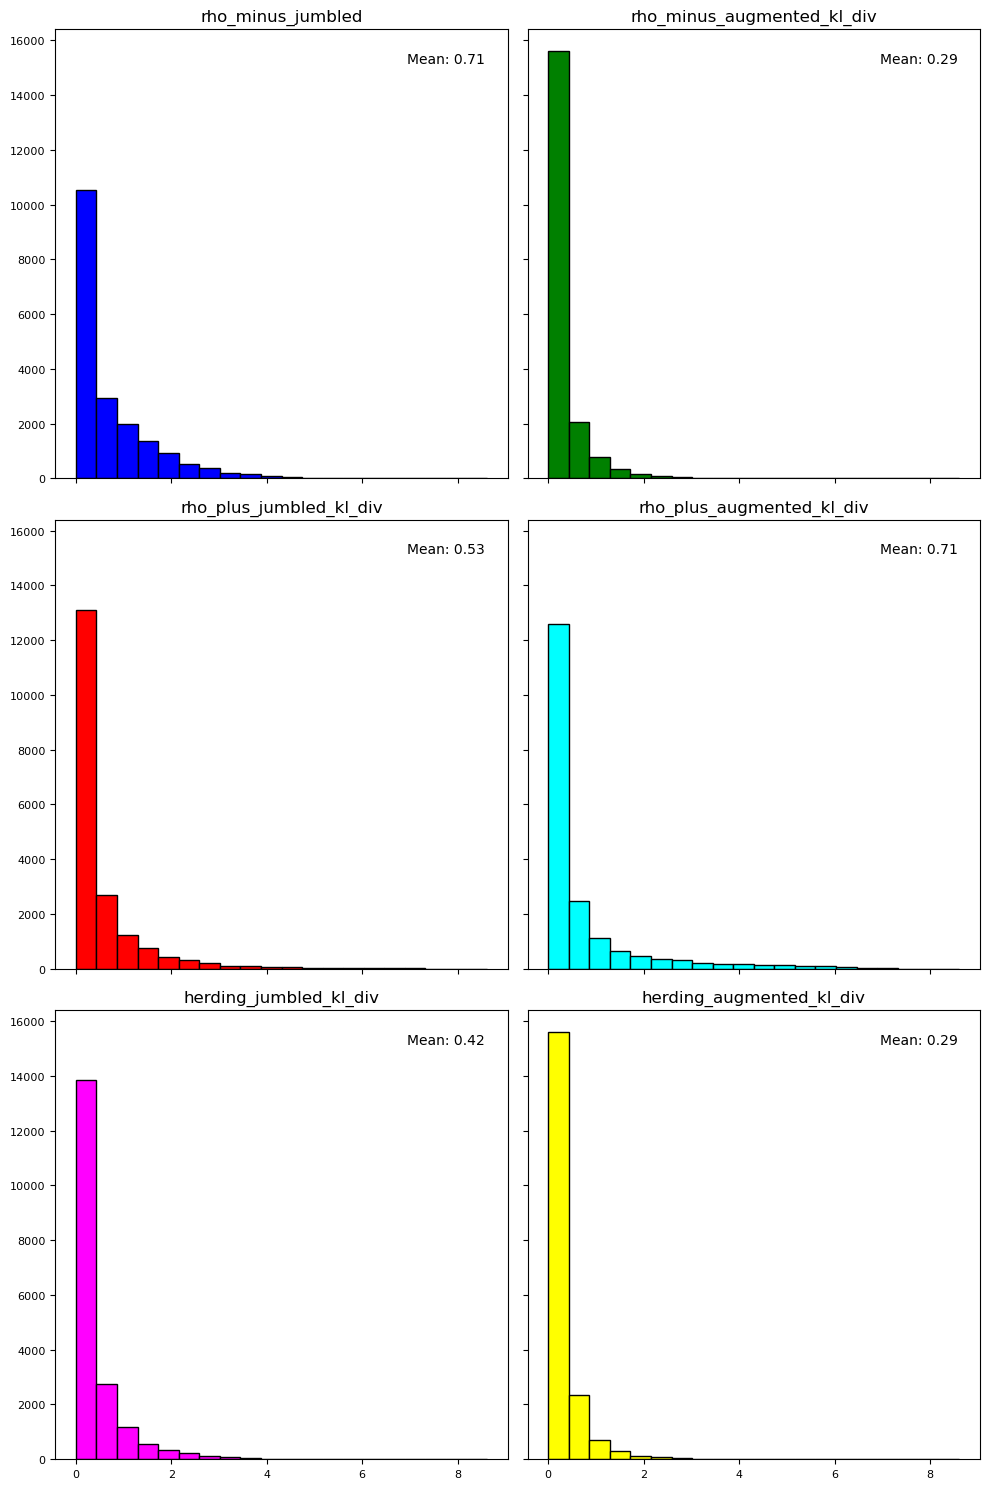

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15), sharex=True, sharey=True)

# List of data and their titles
data = [rho_minus_jumbled, rho_minus_augmented_kl_div, rho_plus_jumbled_kl_div, 
        rho_plus_augmented_kl_div, herding_jumbled_kl_div, herding_augmented_kl_div]
titles = ["rho_minus_jumbled", "rho_minus_augmented_kl_div", "rho_plus_jumbled_kl_div", 
          "rho_plus_augmented_kl_div", "herding_jumbled_kl_div", "herding_augmented_kl_div"]

# Colors for each histogram
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# Sizes for titles, labels, and mean text
title_size = 12  # Size for the titles
label_size = 8   # Size for the axis labels
text_size = 10   # Size for the mean text

# Determine common limits for the X and Y axes
all_data = np.concatenate(data)
bins = np.linspace(np.min(all_data), np.max(all_data), 21)

# Create the histograms
for ax, d, title, color in zip(axs.flatten(), data, titles, colors):
    ax.hist(d, bins=bins, color=color, edgecolor='black')
    ax.set_title(title, fontsize=title_size)
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    mean_val = np.mean(d)
    ax.text(0.95, 0.95, f'Mean: {mean_val:.2f}', transform=ax.transAxes, 
            fontsize=text_size, verticalalignment='top', horizontalalignment='right')

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()


##### Range = [0, 4]

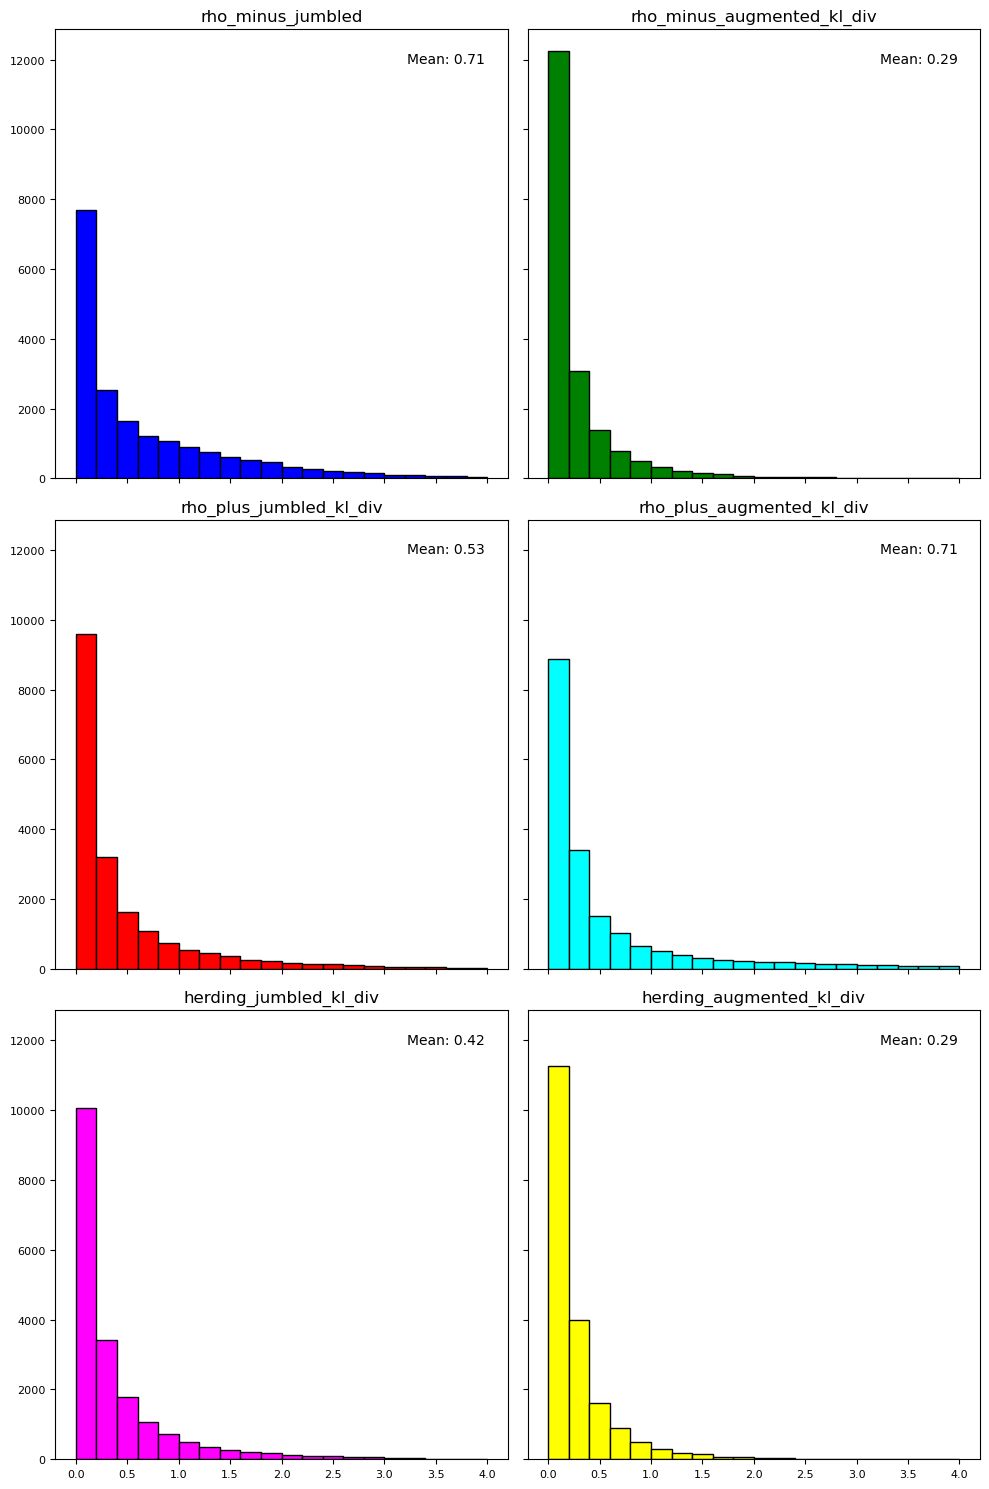

In [7]:
# Code modification to limit the X-axis range between 0 and 4 for all histograms

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15), sharex=True, sharey=True)

# List of data and their titles
data = [rho_minus_jumbled, rho_minus_augmented_kl_div, rho_plus_jumbled_kl_div, 
        rho_plus_augmented_kl_div, herding_jumbled_kl_div, herding_augmented_kl_div]
titles = ["rho_minus_jumbled", "rho_minus_augmented_kl_div", "rho_plus_jumbled_kl_div", 
          "rho_plus_augmented_kl_div", "herding_jumbled_kl_div", "herding_augmented_kl_div"]

# Colors for each histogram
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# Sizes for titles, labels, and mean text
title_size = 12  # Size for the titles
label_size = 8   # Size for the axis labels
text_size = 10    # Size for the mean text

# Determine common limits for the X and Y axes
bins = np.linspace(0, 4, 21)

# Create the histograms
for ax, d, title, color in zip(axs.flatten(), data, titles, colors):
    ax.hist(d, bins=bins, color=color, edgecolor='black', range=(0, 4))
    ax.set_title(title, fontsize=title_size)
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    mean_val = np.mean(d)
    ax.text(0.95, 0.95, f'Mean: {mean_val:.2f}', transform=ax.transAxes, 
            fontsize=text_size, verticalalignment='top', horizontalalignment='right')

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()

#### Dif-in-means

In [8]:
print(f"Mean difference in means for rho- between the jumbled and base: {DIM_jumbled[0].mean()}")
print(f"Mean difference in means for rho- between the augmented and base: {DIM_augmented[0].mean()}")
print("################################")
print(f"Mean difference in means for rho+ between the jumbled and base: {DIM_jumbled[1].mean()}")
print(f"Mean difference in means for rho+ between the augmented and base: {DIM_augmented[1].mean()}")
print("################################")
print(f"Mean difference in means for herding between the jumbled and base: {DIM_jumbled[2].mean()}")
print(f"Mean difference in means for herding between the augmented and base: {DIM_augmented[2].mean()}")
print("################################")

Mean difference in means for rho- between the jumbled and base: -0.0410504665389599
Mean difference in means for rho- between the augmented and base: -0.0483071934443433
################################
Mean difference in means for rho+ between the jumbled and base: 0.030625245678143974
Mean difference in means for rho+ between the augmented and base: -0.05186141113003394
################################
Mean difference in means for herding between the jumbled and base: 0.03553977224902338
Mean difference in means for herding between the augmented and base: 0.005466555890918247
################################


In [9]:
print(f"Mean difference in means for p_5 between the jumbled and base: {DIM_jumbled[3].mean()}")
print(f"Mean difference in means for p_5 between the augmented and base: {DIM_augmented[3].mean()}")
print("################################")
print(f"Mean difference in means for p_4 between the jumbled and base: {DIM_jumbled[4].mean()}")
print(f"Mean difference in means for p_4 between the augmented and base: {DIM_augmented[4].mean()}")
print("################################")
print(f"Mean difference in means for p_2 between the jumbled and base: {DIM_jumbled[5].mean()}")
print(f"Mean difference in means for p_2 between the augmented and base: {DIM_augmented[5].mean()}")
print("################################")
print(f"Mean difference in means for p_1 between the jumbled and base: {DIM_jumbled[6].mean()}")
print(f"Mean difference in means for p_1 between the augmented and base: {DIM_augmented[6].mean()}")
print("################################")
print(f"Mean difference in means for bias_5_star between the jumbled and base: {DIM_jumbled[7].mean()}")
print(f"Mean difference in means for bias_5_star between the augmented and base: {DIM_augmented[7].mean()}")

Mean difference in means for p_5 between the jumbled and base: 0.04869473795325027
Mean difference in means for p_5 between the augmented and base: -0.11441913199194824
################################
Mean difference in means for p_4 between the jumbled and base: -0.015868387885597243
Mean difference in means for p_4 between the augmented and base: -0.04474870567310426
################################
Mean difference in means for p_2 between the jumbled and base: -0.020233150928775992
Mean difference in means for p_2 between the augmented and base: -0.005793911778397151
################################
Mean difference in means for p_1 between the jumbled and base: -0.03309577880620779
Mean difference in means for p_1 between the augmented and base: -0.04951584386908503
################################
Mean difference in means for bias_5_star between the jumbled and base: -0.005960861789208155
Mean difference in means for bias_5_star between the augmented and base: -0.04431385564334050